In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.linear_model import RidgeCV,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import flammkuchen as fl

In [2]:
catname = np.array(['AS', 'S1', 'S2', 'BS', 'JT', 'HAT', 'RT', 'SAT',
       'OB', 'LLC', 'SLC'])
bout_cols=  ['#82cfff','#4589ff','#0000c8','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']
bout_cat =np.arange(0,11,1)

bt_names = dict()
bt_names['bout_names'] = catname
bt_names['bout_cat'] = bout_cat
bt_names['bout_cols'] = bout_cols

# np.savez(master_path/ 'bout_names_kk', **bt_names)  # data is a dict here

In [3]:
SAVE_FIGS=True
fig_dir = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_5\fig_5')
fig_dir.mkdir(exist_ok=True, parents=True)

## Load data

In [4]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\fin_tail_nn')
ds = np.load(Path(master_path /'fin_data'/'model_data_test.npz'))
print(*ds.files,sep="\n")

original_index
proba
clusters
tail_dir
tails
fins
reconstructions
latents
inputs
model_targets
original_tensor


In [5]:
ds = np.load(Path(master_path /'fin_data'/'model_data_test.npz'))
ds['reconstructions'].shape, ds['tails'].shape, ds['model_targets'].shape, ds['inputs'].shape,  ds['fins'].shape, ds['latents'].shape

((1823, 7, 175),
 (1824, 7, 175),
 (1823, 7, 175),
 (1823, 10, 175),
 (1824, 2, 175),
 (1823, 120, 175))

In [6]:
# pull out bout features
swim_cat = ds['clusters'] # bout type
swim_direction = ds['tail_dir'] # direction
proba = ds['proba'] # direction

# pull out bout tensors
fins = ds['fins'][:-1,:,:]
# fins = ds['fin_upsamp']
# tails = ds['tail_upsamp']

tails = ds['tails'][:-1,:,:]
latents = ds['latents']
inputs = ds['inputs']
recons = ds['reconstructions']

# dims
n_trials, n_segs, n_tps = recons.shape
_, n_fins, _ = fins.shape
_, n_latents, _ = latents.shape
_, n_inputs, _ = inputs.shape

print(f"n trials: {n_trials}, n tps: {n_tps}, n fins: {n_fins}, n latents: {n_latents}")

tt_ = np.arange(n_tps)*10/7

n trials: 1823, n tps: 175, n fins: 2, n latents: 120


## Fit tail latents to fin

In [7]:

# Assuming latents as features (X) and fins as target (y)
print(latents.shape, fins.shape)
X = latents.reshape(latents.shape[0], -1)  # Flatten the latents array
y = fins.reshape(fins.shape[0], -1)  # Flatten the fins array
print(X.shape, y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, y_train = X, y

# Define the Ridge regression model with cross-validation
alphas = [1e-4, 1e-3, 0.01, 0.1, 1.0,]  # List of alphas to cross-validate
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_cv.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Best alpha: {ridge_cv.alpha_}')

(1823, 120, 175) (1823, 2, 175)
(1823, 21000) (1823, 350)
Mean Squared Error: 0.08227821428837706
Best alpha: 1.0


In [8]:
# np.random.seed(2)
np.random.seed(3)

ytrain_pred = ridge_cv.predict(X_train)
sk_ytrain_=ytrain_pred.reshape(ytrain_pred.shape[0],n_fins,n_tps).transpose(0,2,1)
sk_ytrain_true_=y_train.reshape(ytrain_pred.shape[0],n_fins,n_tps).transpose(0,2,1)


In [9]:
print(f"Train mse: {mean_squared_error(y_train, ytrain_pred):.04f}\tTest mse: {mean_squared_error(y_test, y_pred):.04f}")

Train mse: 0.0201	Test mse: 0.0823


## Calculate r-score for all bout

In [10]:
# Predict on the test set
ridge_cv.fit(X, y)
y_pred_ = ridge_cv.predict(X)

sk_y_=y_pred_.reshape(y_pred_.shape[0],n_fins,n_tps).transpose(0,2,1)
sk_ytrue_=y.reshape(y_pred_.shape[0],n_fins,n_tps).transpose(0,2,1)

r_vals = np.array([r2_score(tr, pr) for tr, pr in zip(y, y_pred_)])
r_vals.shape

(1823,)

In [11]:
means, errs, seq1, seq2 = [], [], [], []
for a_cat in range(len(bout_cat)):
    if a_cat ==10:
        print (a_cat)
        ids_ = np.where(swim_cat==a_cat)[0][:-1]
        print(catname[a_cat],ids_.shape)
        # print(ids_)
        means.append(np.mean(r_vals[ids_]))
        seq1.append(r_vals[ids_][r_vals[ids_]>0.0])
        seq2.append(np.clip(r_vals[ids_],0,None))
        errs.append(np.std(r_vals[ids_]))
        
    else:
        print (a_cat)
        ids_ = np.where(swim_cat==a_cat)[0]
        print(catname[a_cat],ids_.shape)
        # print(ids_)
        means.append(np.mean(r_vals[ids_]))
        seq1.append(r_vals[ids_][r_vals[ids_]>0.0])
        seq2.append(np.clip(r_vals[ids_],0,None))
        errs.append(np.std(r_vals[ids_]))
    
means, errs = np.array(means), np.array(errs)

0
AS (200,)
1
S1 (200,)
2
S2 (200,)
3
BS (200,)
4
JT (200,)
5
HAT (200,)
6
RT (200,)
7
SAT (186,)
8
OB (6,)
9
LLC (200,)
10
SLC (31,)


In [12]:
import flammkuchen as fl
fl.save(master_path/ 'R2_sample.h5', seq2)

### Result plot

In [13]:
proba_means, proba_errs= [], []
for a_cat in range(len(bout_cat)):
    if a_cat ==10:
        print (a_cat)
        ids_ = np.where(swim_cat==a_cat)[0][:-1]
        print(catname[a_cat],ids_.shape)
        proba_means.append(np.mean(proba[ids_]))
        proba_errs.append(np.std(proba[ids_]))
        
    else:
        print (a_cat)
        ids_ = np.where(swim_cat==a_cat)[0]
        print(catname[a_cat],ids_.shape)
        proba_means.append(np.mean(proba[ids_]))
        proba_errs.append(np.std(proba[ids_]))
    
proba_means, proba_errs = np.array(proba_means), np.array(proba_errs)

0
AS (200,)
1
S1 (200,)
2
S2 (200,)
3
BS (200,)
4
JT (200,)
5
HAT (200,)
6
RT (200,)
7
SAT (186,)
8
OB (6,)
9
LLC (200,)
10
SLC (31,)


### Plot the fins with r2-score

In [14]:
lw=0.5
cm = 1/2.54  # centimeters in inches
f_size = 6
dpi= 600
plt.rcParams.update({'font.size': f_size})

C:\Users\admin\AppData\Local\Temp\ipykernel_6292\1242016317.py:83: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


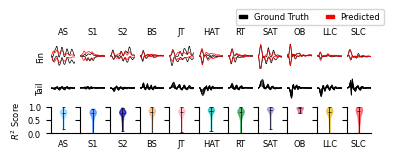

In [19]:
import matplotlib.patches as mpatches
# plot example bout fins and the r2-score

np.random.seed(1)
fig, ax = plt.subplots(facecolor='None',figsize=(10.5*cm, 3*cm))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

G = gridspec.GridSpec(3,len(np.unique(swim_cat)), height_ratios=[1,1,1])
ax0 = {}
for i,b in enumerate(bout_cat):
    ax0 = plt.subplot(G[0,i])
    ax0.set_title(catname[i],fontsize=f_size, c='k' ) #bout_cols[i]) 
    id = np.where(swim_cat==b)[0]
    if len(id)>0:
        id_ = np.random.choice(id)
        ax0.plot(sk_ytrue_[id_],color='k', lw=lw)
        ax0.plot(sk_y_[id_],color='r', lw=lw)
    ax0.set(xticks=[], yticks=[], xlim=(0,160), ylim=(-1.5,1.5),)
    for sp in ['top','bottom','left','right']:
        ax0.spines[sp].set_color('none')  # Turns off the spines
        
    ax1 = plt.subplot(G[1,i])
    if len(id)>0:
        [ax1.plot(tails[id_,i_,:], color="k", lw=lw) for i_ in range(7)]
  
    ax1.set(xticks=[], yticks=[], xlim=(0,160), ylim=(-4,4),)
    for sp in ['top','bottom','left','right']:
        ax1.spines[sp].set_color('none')  # Turns off the spines
    if seq1[i].size==0:
        continue
    
    ax2 = plt.subplot(G[2,i])
    parts = ax2.violinplot(seq1[i], showmeans=False, showmedians=True, widths=0.5)
    parts['bodies'][0].set_facecolor(bout_cols[b])
    parts['bodies'][0].set_edgecolor(bout_cols[b])
    parts['bodies'][0].set_alpha(0.7)
    
    # Set color and linewidth of median line to black and thinner
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linewidth(0.5)
        # Set color of the vertical lines (whiskers) to black
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    parts['cmins'].set_linewidth(0.5)
    parts['cmaxes'].set_linewidth(0.5)
    # Set color of the central line connecting median and whiskers to black
    parts['cbars'].set_color('black')
    parts['cbars'].set_linewidth(0.5)
    
    ax2.set(yticks=[0, 0.5, 1])
    ax2.set_xticks(np.arange(0, 3))
    ax2.set(xticks=[], xlabel=catname[b], ylim=(0,1))
    for sp in ['top','right']:
        ax2.spines[sp].set_color('none')  # Turns off the spines
    
    # Remove y-tick labels from every subplot except the first one
    if i != 0:
        ax2.set_yticklabels([])

# Create custom legend patches
ground_truth_patch = mpatches.Patch(color='k', label='Ground Truth')
predicted_patch = mpatches.Patch(color='r', label='Predicted')

# Add the patches to the legend
ax0.legend(handles=[ground_truth_patch, predicted_patch], loc='upper center', bbox_to_anchor=(-1.5, 2.4),ncol=2,
           handleheight=0.3,  # Adjust handle height
           handlelength=1)    # Adjust handle length


ax0 = plt.subplot(G[0,0])
ax0.set_ylabel("Fin", fontsize=f_size)
ax1 = plt.subplot(G[1,0])
ax1.set_ylabel("Tail", fontsize=f_size)
ax2 = plt.subplot(G[2,0])
ax2.set_ylabel("$R^{2}$ Score", fontsize=f_size)

plt.tight_layout()

fig.savefig(fig_dir / "r2_fins_w_bouts_mod.pdf", bbox_inches='tight',dpi=dpi, transparent=True)
fig.savefig(fig_dir / "r2_fins_w_bouts_mod.png", bbox_inches='tight',dpi=dpi, transparent=True)